# Классификаиция клиентов телеком компании

**Описание проекта**: Оператор мобильной связи выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям один из новых тариф: Smart или Ultra

**Задача проекта**: На основе данных предложить клиенту тариф.

**Описание данных:**

Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. Известно:

- `сalls` — количество звонков,
- `minutes` — суммарная длительность звонков в минутах,
- `messages` — количество sms-сообщений,
- `mb_used` — израсходованный интернет-трафик в Мб,
- `is_ultra` — каким тарифом пользовался в течение месяца («Ultra» — 1, «Smart» — 0).

## Изучение файла

Импортируем необходимые библиотеки

In [1]:
# импорты из стандартной библиотеки
import warnings

# импорты сторонних библиотек
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# импорты модулей текущего проекта
from tqdm import tqdm
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier

# настройки
warnings.filterwarnings("ignore")

# константы
RANDOM_STATE = 12345

In [2]:
# считываем файл и сразу же смотрим
users_behavior = pd.read_csv('users_behavior.csv')
users_behavior.head()

,Unnamed: 0,calls,minutes,messages,mb_used,is_ultra
0,0,40.0,311.90,83.0,19915.42,0
1,1,85.0,516.75,56.0,22696.96,0
2,2,77.0,467.66,86.0,21060.45,0
3,3,106.0,745.53,81.0,8437.39,1
4,4,66.0,418.74,1.0,14502.75,0


Сразу заметим лишний столбец 'Unnamed: 0' - он просто дублирует индексы, посему его удалим.

In [3]:
# удаляем лишний столбец
users_behavior = users_behavior.drop('Unnamed: 0', axis=1)

In [4]:
# выводим общую информацию о датасете
users_behavior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Пропущенных значений нет, проблем с типами данных тоже.

In [5]:
# посмотрим также и на основные статистики
users_behavior.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Посмотрим на отношение классов в таргете `is_ultra`

In [6]:
users_behavior['is_ultra'].value_counts(normalize=True)

0    0.693528
1    0.306472
Name: is_ultra, dtype: float64

Видно, что дисбаланс классов *есть*, доля пользователей с тарифом Smart - 0.69, а с тарифом Ultra - 0.31

Но на модели, которые мы будем рассматривать, это [особо не повлияет](https://habr.com/ru/post/349078/), можем не переживать на этот счет.

Посмотрим также и на корелляцию признаков.

In [7]:
users_behavior.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


Для большей наглядности построим heatmap

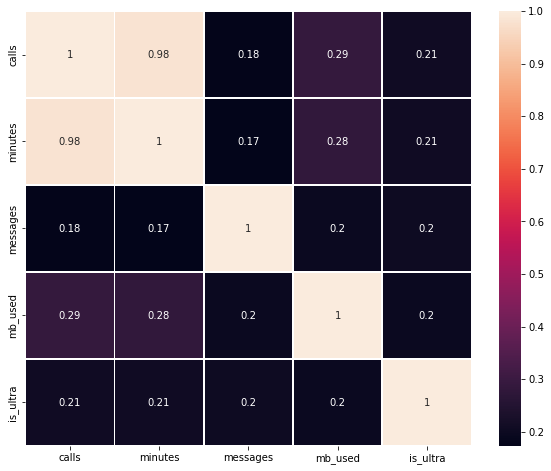

In [8]:
plt.figure(figsize=(10, 8))

sns.heatmap(data=users_behavior.corr(), annot=True, linewidth=.7);

Заметим, что между признаками `calls` и `minutes` наблюдается *мультиколлинеарность*. Можно сделать следующий вывод:
- достаточно одного из этих параметров, чтобы модель могла обучиться и давать адекватные результаты (для линейных)
- важна интерпретируемость линейной модели т.к. по коэффициентам мы судим как признаки влияют на таргет
- посему, один из признаков **удалим**

In [9]:
# удаляем столбец 'minutes'
users_behavior.drop('minutes', axis=1, inplace=True)

Похоже, что теперь с данными все в порядке, на первый взгляд ничего не вызывает подозрений. 

*Можно работать*

## Сплит данных на выборки

Так как отдельной тестовой выборки нет - делим users_behavior в соотношении 3:1:1

X - набор обучающих признаков  
y - таргет

In [10]:
X = users_behavior.drop('is_ultra', axis=1)
y = users_behavior['is_ultra']

In [11]:
print(f'Кол-во строк до сплитов = {X.shape[0]}')

Кол-во строк до сплитов = 3214


Для начала отделим *тренировочную часть* - 60%

Укажем параметр stratify=y для сохранения отношения классов

In [12]:
X_train, X_rem, y_train, y_rem = train_test_split(X, y, train_size=0.6, stratify=y, random_state=RANDOM_STATE)

Оставшиеся 40% от данных *делим пополам*, тем самым получим **валидационную** и **тестовую** выборки

In [13]:
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.5, stratify=y_rem, random_state=RANDOM_STATE)

Проверим количество строк после сплитов

In [14]:
print(f'X_train = {X_train.shape[0]}')
print(f'  X_val = {X_val.shape[0]}')
print(f' X_test = {X_test.shape[0]}')
print(f'  total = {X_train.shape[0] + X_val.shape[0] + X_test.shape[0]}')

X_train = 1928
  X_val = 643
 X_test = 643
  total = 3214


Все сходится! Теперь посмотрим, помог ли параметр `stratify` сохранить отношение классов 0 (Smart) и 1 (Ultra)

In [15]:
y_train.value_counts(normalize=True)

0    0.693465
1    0.306535
Name: is_ultra, dtype: float64

In [16]:
y_val.value_counts(normalize=True)

0    0.693624
1    0.306376
Name: is_ultra, dtype: float64

In [17]:
y_test.value_counts(normalize=True)

0    0.693624
1    0.306376
Name: is_ultra, dtype: float64

*Все отлично*, дисбаланс никуда не делся, но он будет одинаковым во всех выборках

## Исследование моделей

Мною было решено исследовать три *классические модели*: 
1. DecisionTreeClassifier 
2. RandomForestClassifier
3. LogisticRegression

### DecisionTreeClassifier

С помощью вложенных циклов потюним следующие гиперпараметры дерева: `criterion`, `max_depth`, `min_samples_leaf`, `min_samples_split`, для сохранения результатов используем `random_state=RANDOM_STATE`.

Можно было бы использовать `GridSearchCV`, но я сделал так, также, используем tqdm для визуализации итераций.

In [18]:
best_dt = None
best_dt_result = 0

# в цикле переберем гиперпараметры (max_depth и min_samples_leaf)
for depth in tqdm(range(1, 51)):
    for s_leaf in range(1, 16):
        
        # присваиваем переменной dt_model модель дерева решений с гиперпараметрами из текущей итерации
        dt_model = DecisionTreeClassifier(
            max_depth=depth, min_samples_leaf=s_leaf, random_state=RANDOM_STATE
        )
        
        # тут же и фиттим модель
        dt_model.fit(X_train, y_train)
                
        # предсказываем и считаем accuracy на валидационной выборке
        predictions_val = dt_model.predict(X_val)
        result = accuracy_score(y_val, predictions_val)
                
        # если получившийся результат лучше best_dt_result запишем его и текущие гиперпараметры
        if result > best_dt_result:
            best_dt = dt_model
            best_dt_result = result
            best_depth = depth
            best_s_leaf = s_leaf


# выведем результаты
print(f'Качество и параметры лучшей модели на валидационной выборке:')
print(f'Accuracy: {best_dt_result:.3}, Глубина дерева: {best_depth}, min_samples_leaf: {best_s_leaf}')

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  8.64it/s]

Качество и параметры лучшей модели на валидационной выборке:
Accuracy: 0.802, Глубина дерева: 5, min_samples_leaf: 11


**`Промежуточный вывод:`**

Результат получился неплохим, accuracy на валидационной выборке для dt = 0.802

Можем также и визуализировать дерево, чтобы понять какой логике оно следовало.

Ограничим max_depth = 3 для удобства.

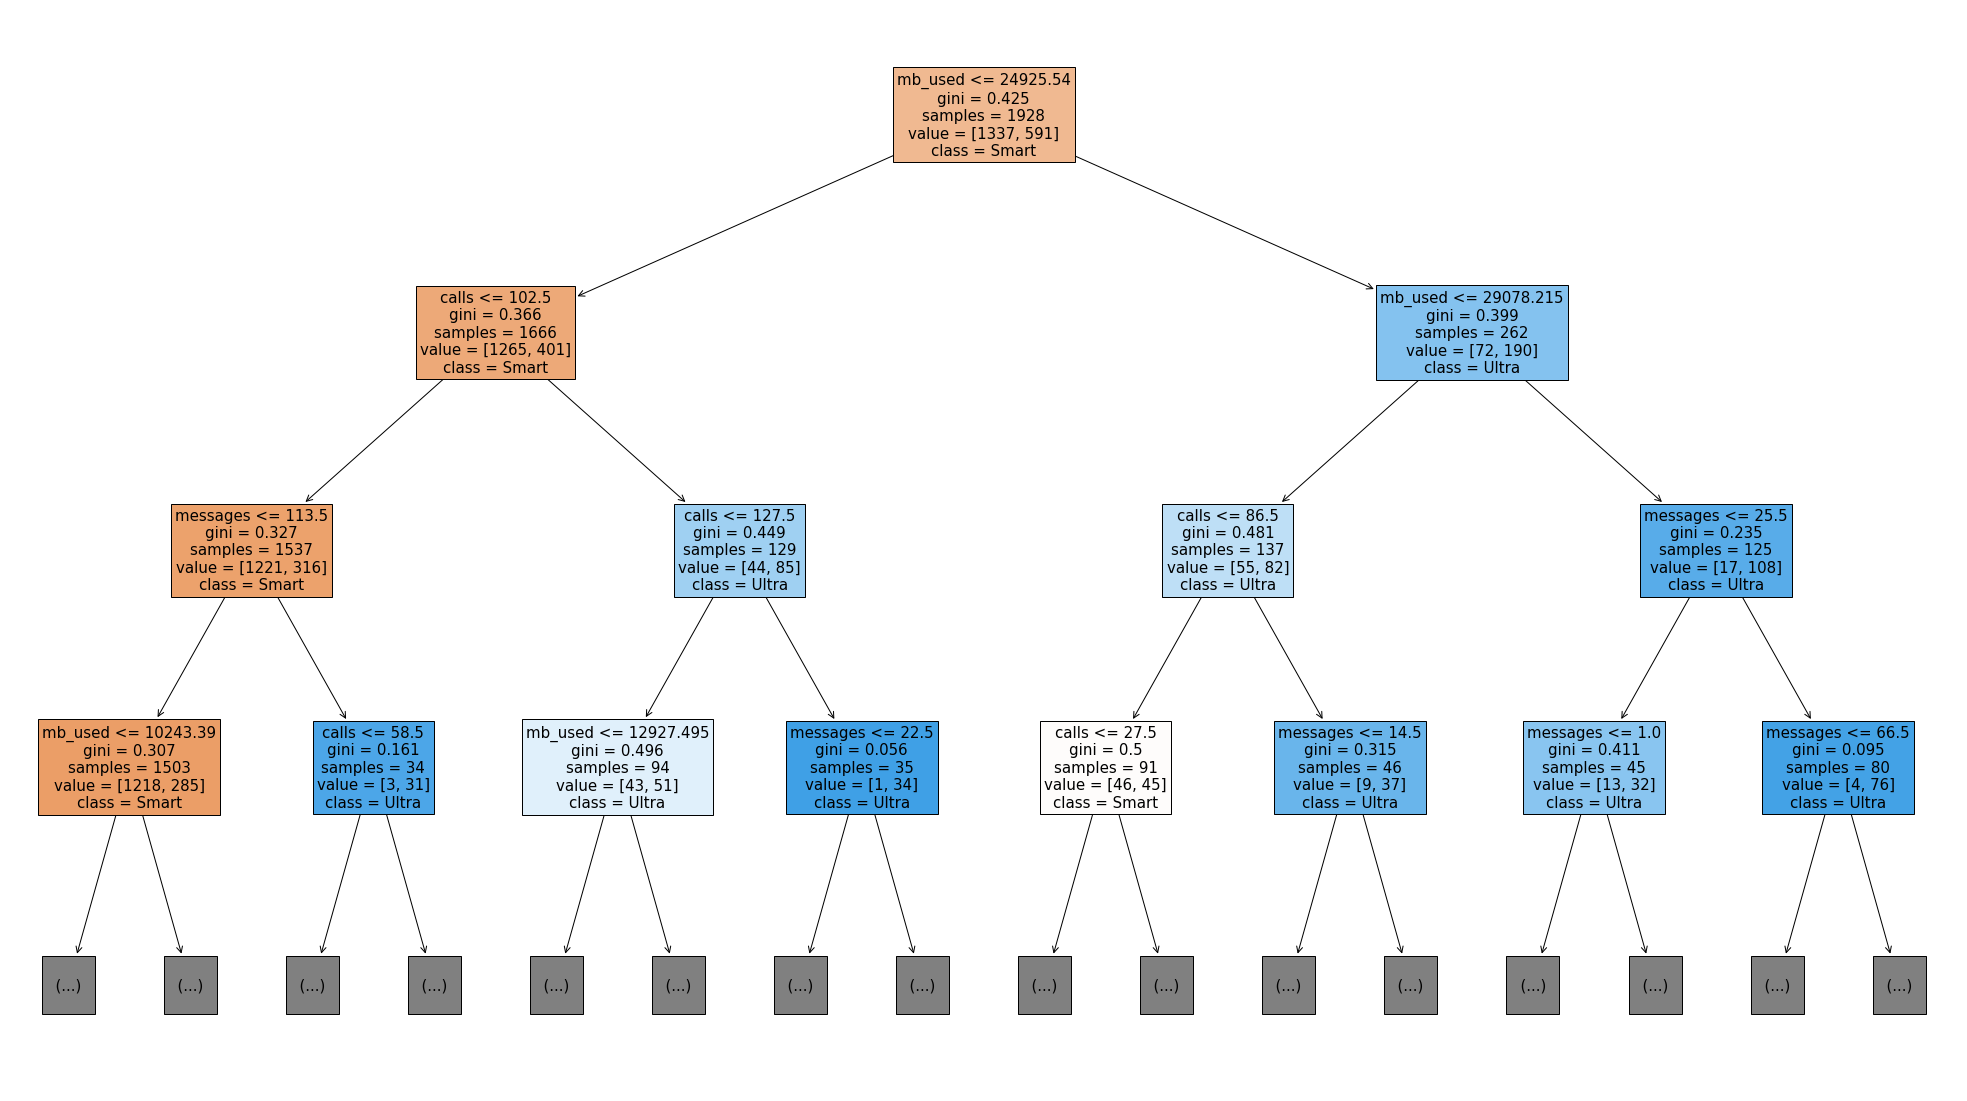

In [19]:
fig = plt.figure(figsize=(35,20))
_ = plot_tree(best_dt, 
              feature_names=X.columns.values, 
              class_names=['Smart','Ultra'],
              filled=True,
              fontsize = 15,
              max_depth = 3
             )

### RandomForestClassifier

С помощью вложенных циклов потюним следующие гиперпараметры леса: `n_estimators`, `max_depth`, для сохранения результатов используем `random_state=RANDOM_STATE`. Я не стал брать еще и `min_samples_leaf`, `min_samples_split` т.к. тюнинг модели и так слишком долгий.

Опять же, можно было бы использовать `GridSearchCV`, в этом проекте я решил пойти ручным путем.

In [20]:
best_rf = None
best_rf_result = 0

# в цикле переберем гиперпараметры (n_estimators и max_depth)
for est in tqdm(range(1, 51)):  
    for depth in range(1, 11):
        
        # присваиваем переменной rf_model модель случайного леса с гиперпараметрами из текущей итерации
        rf_model = RandomForestClassifier(
            n_estimators=est, max_depth=depth, random_state=RANDOM_STATE
        )
            
        # тут же фиттим
        rf_model.fit(X_train, y_train)
            
        # предсказываем и считаем accuracy на валидационной выборке
        predictions_val = rf_model.predict(X_val)
        result = accuracy_score(y_val, predictions_val)
            
        # если получившийся результат лучше best_rf_result запишем его и текущие гиперпараметры
        if result > best_rf_result:
            best_rf = rf_model
            best_rf_result = result
            best_est = est
            best_depth = depth


# выведем результаты
print(f'Качество и параметры лучшей модели на валидационной выборке:')
print(f'Accuracy: {best_rf_result:.3}, Количество деревьев: {best_est}, Глубина дерева: {best_depth}')

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:30<00:00,  1.64it/s]

Качество и параметры лучшей модели на валидационной выборке:
Accuracy: 0.82, Количество деревьев: 26, Глубина дерева: 9


**`Промежуточный вывод:`**

Неплохой результат! Как и ожидалось, результат больше чем у дерева решений.

Accuracy на валидационной выборке для rf = 0.82

### LogisticRegression

Здесь я просто выставил `max_iter=200` и для сохранения результатов использовал `random_state=RANDOM_STATE`.

In [21]:
# присваиваем переменной lr_model модель логистической регрессии
lr_model = LogisticRegression(max_iter=200, random_state=RANDOM_STATE)
lr_model.fit(X_train, y_train)

# предсказываем и считаем accuracy на валидационной выборке
predictions_val = lr_model.predict(X_val)
result = accuracy_score(y_val, predictions_val)

# выведем результаты
print(f'Accuracy модели на валидационной выборке: {result:.3}')

Accuracy модели на валидационной выборке: 0.74


**`Промежуточный вывод:`**

Результат на тестовой выборке получился *такой себе*, *худший* из трех рассмотренных моделей. 

Для улучшения метрики здесь можно попробовать отмасштабировать признаки `StandardScaler`-ом т.к. они все числовые.

## Проверка лучшей модели на тестовой выборке

При проверке лучшей модели, будем обучать её на *сконкаченных данных* (train + validation)

In [22]:
print(f'Кол-во строк в train + val выборке = {X_train.shape[0] + X_val.shape[0]}')

Кол-во строк в train + val выборке = 2571


In [23]:
# объединяем train и val выборки
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

# сразу проверим кол-во строк
print(f'Кол-во строк в объединенной выборке = {X_train_val.shape[0]}')

Кол-во строк в объединенной выборке = 2571


In [24]:
# обучим на train + val выборке
best_rf.fit(X_train_val, y_train_val)

# предиктим и считаем accuracy на тестовой выборке
test_predictions = best_rf.predict(X_test)
train_val_rf_score = accuracy_score(y_test, test_predictions)

# выведем метрику на экран
print(f'Accuracy лучшей модели на тестовой выборке = {train_val_rf_score:.3}')

Accuracy лучшей модели на тестовой выборке = 0.823


Отлично, метрика даже **немного улучшилась**: на *валидационной* было 0.82, а на *тестовой* стало 0.823

## Проверка лучшей модели на адекватность

В задачах классификации для оценки адекватности модели ее нужно сравнить со случайной, используем для этого `DummyClassifier` из библиотеки *sklearn*

In [25]:
# инициализируем dummy классификатор и фиттим на train_val выборке
dum_dum = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dum_dum.fit(X_train_val, y_train_val)

# проверяем на тестовой выборке
dummy_pred = dum_dum.predict(X_test)
train_val_dummy_score = accuracy_score(y_test, dummy_pred)

print('Сравнение результатов DummyClassifier с лучшей моделью:')
print()
print(f'_dum dum: {train_val_dummy_score:.3}')
print(f'rf_model: {train_val_rf_score:.3}')

Сравнение результатов DummyClassifier с лучшей моделью:

_dum dum: 0.694
rf_model: 0.823


В сравнении видно, что наша модель, в общем-то *адекватна* и показывает *результат явно лучший чем dummy*!

## Общий вывод

1. **`Изучение файла:`**
    - Датафрейм *users_behavior* был без пропусков и проблем с типами данных


2. **`Сплит данных на выборки:`**
    - Данные были разбиты на выборки в соответствии с отношением 3:1:1
    - Для разбития датафрейма на выборки был применен метод `train_test_split()` два раза


3. **`Исследование моделей:`**
    - Было исследовано три типа моделей (дерево решений, случайный лес и логистическая регрессия)

    - *Дерево решений* дало неплохой результат: 
        - Accuracy лучшего дерева решений на валидационной выборке: 0.802
        - Параметры лучшего дерева решений (max_depth=5, min_samples_leaf=11)

    - *Случайный лес* дал результат еще лучше:
        - Accuracy лучшего случайного леса на валидационной выборке: 0.82
        - Параметры лучшего случайного леса (n_estimators=26, max_depth=9)

    - *Логистическая регрессия* дала непонятный мне результат:
        - Accuracy лучшей лог регрессии на валидационной выборке: 0.74
        - В параметрах, помимо random_state был указан только max_iter=200


4. **`Проверка лучшей модели на тестовой выборке:`**
    - Случайный лес дал результат еще лучше: 0.823


5. **`Проверка лучшей модели на адекватность:`**
    - Относительно dummy классификатора модель адекватна


6. **`Итог:`**
    - Случайный лес молодец и победитель